# Tutorial: Data-driven System Identification with SINDy

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mathLab/PINA/blob/master/tutorials/tutorial23/tutorial.ipynb)


> ##### ⚠️ ***Before starting:***
> We assume you are already familiar with the concepts covered in the [Getting started with PINA](https://mathlab.github.io/PINA/_tutorial.html#getting-started-with-pina) tutorial. If not, we strongly recommend reviewing them before exploring this advanced topic.

In this tutorial, we will demonstrate a typical use case of **PINA** for Data-driven system identification using SINDy. The tutorial is largely inspired by the paper [Discovering governing equations from data by sparse identification of nonlinear dynamical systems](dx.doi.org/10.1073/pnas.1517384113).

Let's start by importing the useful modules:

In [1]:
## routine needed to run the notebook on Google Colab
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    !pip install "pina-mathlab[tutorial]"

import torch
import numpy as np
import matplotlib.pyplot as plt
import warnings

np.random.seed(0)
warnings.filterwarnings("ignore")

from scipy.integrate import odeint
from pina import Trainer, LabelTensor
from pina.problem.zoo import SupervisedProblem
from pina.solver import SupervisedSolver
from pina.optim import TorchOptimizer
from pina.model import SINDy

## Data generation
In this tutorial, we'll focus on the **identification** of a dynamical system starting only from a finite set of **snapshots**.
More precisely, we'll assume that the dynamics is governed by dynamical system written as follows:
$$\dot{\boldsymbol{x}}(t)=\boldsymbol{f}(\boldsymbol{x}(t)),$$
along with suitable initial conditions.
For simplicity, we'll omit the argument of $\boldsymbol{x}$ from this point onward.

Since $\boldsymbol{f}$ is unknown, we want to model it.
While neural networks could be used to find an expression for $\boldsymbol{f}$, in certain contexts - for instance, to perform long-horizon forecasting - it might be useful to have an **explicit** set of equations describing it, which would also allow for a better degree of **interpretability** of our model.

As a result, we use SINDy (introduced in [this paper](https://www.pnas.org/doi/full/10.1073/pnas.1517384113)), which we'll describe later on.
Now, instead, we describe the system that is going to be considered in this tutorial: the **Lorenz** system.

The Lorenz system is a set of three ordinary differential equations and is a simplified model of atmospheric convection.
It is well-known because it can exhibit chaotic behavior, _i.e._, for given values of the parameters solutions are highly sensitive to small perturbations in the initial conditions, making forecasting extremely challenging.

Mathematically speaking, we can write the Lorenz equations as
$$
\begin{cases}
\dot{x}=\sigma(y-x)\\
\dot{y}=x(\rho-z) - y\\
\dot{z}=xy-\beta z.
\end{cases}
$$
With $\sigma = 10,\, \rho = 28$, and $\beta=8/3$, the solutions trace out the famous butterfly-shaped Lorenz attractor.

With the following lines of code, we just generate the dataset for SINDy and plot some trajectories.

**Disclaimer**: of course, here we use the equations defining the Lorenz system just to generate the data.
If we had access to the dynamical term $\boldsymbol{f}$, there would be no need to use SINDy.

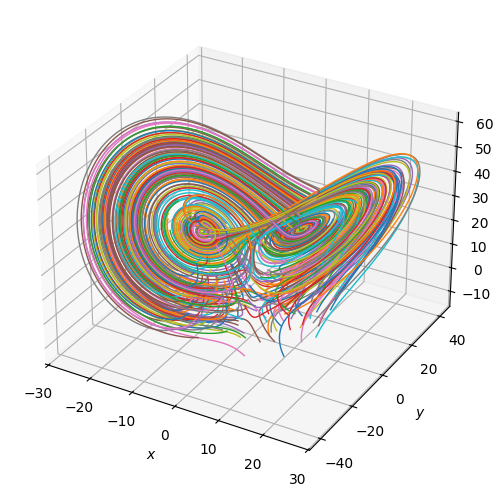

In [2]:
sigma, rho, beta = 10.0, 28.0, 8 / 3


def lorenz(x, t):
    dx = np.zeros(3)
    dx[0] = sigma * (x[1] - x[0])
    dx[1] = x[0] * (rho - x[2]) - x[1]
    dx[2] = x[0] * x[1] - beta * x[2]
    return dx


n_ic_s = 200  # number of initial conditions
T = 1000  # number of timesteps
dt = 0.001  # timestep
t = np.linspace(0, (T - 1) * dt, T)
dim = 3

x0s = (np.random.rand(n_ic_s, dim) - 0.5) * 30.0  # Random initial conditions

X = np.zeros((n_ic_s, T, dim))
for i in range(n_ic_s):
    X[i] = odeint(lorenz, x0s[i], t)  # integrated trajectories


def plot_n_conditions(X, n_to_plot):
    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111, projection="3d")

    for i in range(n_to_plot):
        ax.plot(X[i, :, 0], X[i, :, 1], X[i, :, 2], lw=1)

    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.set_zlabel("$z$")

    plt.tight_layout()
    plt.show()


plot_n_conditions(X, n_ic_s)

## Sparse Identification of Nonlinear Dynamics
The core idea of SINDy is to model $\boldsymbol f$ as a linear combination of functions in a library $\Theta$ of **candidate** functions.
In other words, assume that we have $r$ functions which might be suitable to describe the system's dynamics (_e.g._, $x,\, y,\, x^2,\, xz,\, \dots,\,\sin(x)$, $\dots$).
For each component of $\boldsymbol{f}$ at a given point $\boldsymbol{x}$, we want to write
$$
\dot{x}_i = f_i(\boldsymbol{x}) = \sum_{k}\Theta(\boldsymbol{x})_{k}\xi_{k,i},
$$
with $\boldsymbol{\xi}_i\in\mathbb{R}^r$ a vector of **coefficients** telling us which terms are active in the expression of $f_i$.

Since we are in a supervised setting, we assume that we have at our disposal the snapshot matrix $\boldsymbol{X}$ and a matrix $\dot{\boldsymbol{X}}$ containing time **derivatives** at the corresponding time instances.
Then, we can just impose that the previous relation holds on the data at our disposal.
That is, our optimization problem will read as follows:
$$
\min_{\boldsymbol{\Xi}}\|\dot{\boldsymbol{X}}-\Theta(\boldsymbol{X})\boldsymbol{\Xi}\|_2^2.
$$

Notice, however, that the solution to the previous equation might not be **sparse**, as there might be many non-zero terms in it.
In practice, many physical systems are described by a parsimonious and **interpretable** set of equations.
Thus, we also impose a $L^1$ **penalization** on the model weights, encouraging them to be small in magnitude and trying to enforce sparsity.
The final loss is then expressed as

$$
\min_{\boldsymbol{\Xi}}\bigl(\|\dot{\boldsymbol{X}}-\Theta(\boldsymbol{X})\boldsymbol{\Xi}\|_2^2 + \lambda\|\boldsymbol{\Xi}\|_1\bigr),
$$
with $\lambda\in\mathbb{R}^+$ a hyperparameter.

Let us begin by computing the time derivatives of the data.
Of course, usually we do not have access to the exact time derivatives of the system, meaning that $\dot{\boldsymbol{X}}$ needs to be **approximated**.
Here we do it using a simple Finite Difference (FD) scheme, but [more sophisticated ideas](https://arxiv.org/abs/2505.16058) could be considered.

In [3]:
dXdt = np.gradient(X, t, axis=1, edge_order=2)
X_torch = torch.tensor(X, dtype=torch.float32).reshape(
    (-1, dim)
)  # X_torch has shape (B, dim)
dXdt_torch = torch.tensor(dXdt, dtype=torch.float32).reshape((-1, dim))

We create two `LabelTensor` objects to keep everything as readable as possible.

In [4]:
X_torch = LabelTensor(X_torch, ["x", "y", "z"])
dXdt_torch = LabelTensor(dXdt_torch, ["dxdt", "dydt", "dzdt"])

Now we define the **library of candidate functions**.
In our case, it will consist of polynomials of degree at most $2$ in the state variables.
While the `SINDy` class in **PINA** expects a **list** of callables, here we define also dictionary, as its keys will be used to print the retrieved equations, enhancing the model interpretability and allowing it to be compared to the original Lorenz system.
Notice how readable the code is as a result of the use of the `LabelTensor` class!

In [5]:
function_dict = {
    "1": lambda u: torch.ones(u.shape[0], 1, device=u.device),  # 1
    "x": lambda u: u["x"],  # x
    "y": lambda u: u["y"],  # y
    "z": lambda u: u["z"],  # z
    "x^2": lambda u: u["x"].pow(2),  # x^2
    "y^2": lambda u: u["y"].pow(2),  # y^2
    "z^2": lambda u: u["z"].pow(2),  # z^2
    "xy": lambda u: u["x"] * u["y"],  # xy
    "xz": lambda u: u["x"] * u["z"],  # xz
    "yz": lambda u: u["y"] * u["z"],  # yz
}

function_library = [
    _function for _function in function_dict.values()
]  # input of the model constructor

## Training with PINA
We are now ready to train our model! We can use **PINA** to train the model, following the workflow from previous tutorials.
First, we need to define the problem. In this case, we will use the [`SupervisedProblem`](https://mathlab.github.io/PINA/_rst/problem/zoo/supervised_problem.html#module-pina.problem.zoo.supervised_problem), which expects:  

- **Input**: the state variables tensor $\boldsymbol{X}$ containing all the collected snapshots.  
- **Output**: the corresponding time derivatives $\dot{\boldsymbol{X}}$.

In [6]:
_lambda = 1e-3

model = SINDy(function_library, dim)
problem = SupervisedProblem(X_torch, dXdt_torch)

Finally, we will use the `SupervisedSolver` to perform the training as we're dealing with a supervised problem.

Recall that we should use $L^1$-regularization on the model's weights to ensure sparsity. For the ease of implementation, we adopt $L^2$ regularization, which is less common in SINDy literature but will suffice in our case.
Additionally, more refined strategies could be used, for instance pruning coefficients below a certain **threshold** at every fixed number of epochs, but here we avoid further complications.

In [7]:
solver = SupervisedSolver(
    problem,
    model=model,
    optimizer=TorchOptimizer(torch.optim.Adam, lr=1e-3, weight_decay=_lambda),
    use_lt=False,
)

Training is performed as usual using the **`Trainer`** API.

In [ ]:
trainer = Trainer(
    solver,
    accelerator="cpu",
    max_epochs=150,
    train_size=0.8,
    val_size=0.1,
    test_size=0.1,
    shuffle=True,
    batch_size=512,
    enable_model_summary=False,
)

trainer.train()

Now we'll print the identified equations and compare them with the original ones.

Before going on, we underline that after training there might be many coefficients that are small, yet still non-zero.
It is common for SINDy practitioners to interpret these coefficients as noise in the model and prune them.
This is typically done by fixing a threshold $\tau\in\mathbb{R}^+$ and setting to $0$ all those $\xi_{i,j}$ such that $|\xi_{i,j}|<\tau$.

In the following cell, we also define a function to print the identified model.

In [9]:
def print_coefficients(model, function_names, tau, vars=None):
    with torch.no_grad():
        Xi = model.coefficients.data.cpu().numpy()

    library_dim, dim = Xi.shape

    for j in range(dim):
        terms = []
        for i in range(library_dim):
            coefficient = Xi[i, j]
            if (
                abs(coefficient) > tau
            ):  # do not print coefficients that are going to be pruned
                function_name = function_names[i]
                terms.append(f"{coefficient:+.2f} * {function_name} ")

        equation = " ".join(terms)

        if not equation:
            equation = "0"
        if vars is not None:
            print(f"d{vars[j]}/dt = {equation}")
        else:
            print(f"d(State_{j+1})/dt = {equation}")


tau = 1e-1

print_coefficients(model, list(function_dict.keys()), tau, vars=["x", "y", "z"])

with torch.no_grad():  # prune coefficients
    mask = torch.abs(model.coefficients) >= tau
    model.coefficients.data *= mask

dx/dt = -9.99 * x  +10.00 * y 
dy/dt = +27.99 * x  -0.99 * y  -1.00 * xz 
dz/dt = -2.67 * z  +1.00 * xy 


Good! While there are small errors on some of the coefficients, the active terms in the library have been correctly identified (recall that the original system reads as follows):
$$
\begin{cases}
\dot{x}=-10x+10y\\
\dot{y}=28x - y-xz\\
\dot{z}=-\frac{8}{3} z+xy.
\end{cases}
$$

That's a good result, especially considering that we did not perform tuning on the weight decay hyperparameter $\lambda$ and did not really care much about other optimization parameters.

Let's plot a few trajectories!

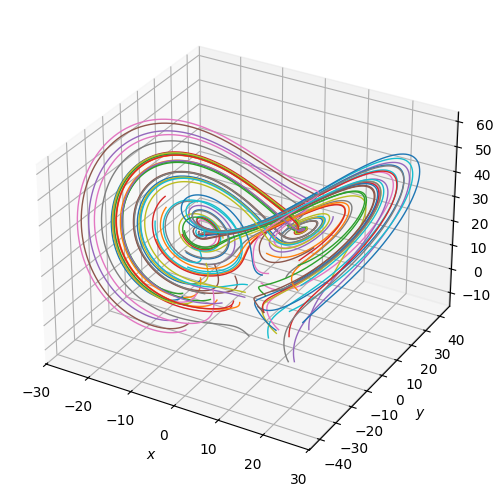

In [10]:
def SINDy_equations(x, t):  # we need a numpy array for odeint
    with torch.no_grad():
        x_torch = torch.tensor(x, dtype=torch.float32).unsqueeze(
            0
        )  # shape (1, dim)
        x_torch = LabelTensor(x_torch, ["x", "y", "z"])
        dx = model(x_torch).squeeze(0)
    return dx.numpy()


n_ic_s_test = 50
x0s = (np.random.rand(n_ic_s_test, dim) - 0.5) * 30.0

X_sim = np.zeros((n_ic_s_test, T, dim))
for i in range(n_ic_s_test):
    X_sim[i] = odeint(SINDy_equations, x0s[i], t)

plot_n_conditions(X_sim, n_ic_s_test)

Great! We can see that the qualitative behavior of the system is really close to the real one.

## What's next?
Congratulations on completing the introductory tutorial on **Data-driven System Identification with SINDy**! Now that you have a solid foundation, here are a few directions to explore:

1. **Experiment with Dimensionality Reduction techniques** — Try to combine SINDy with different reductions techniques such as POD or autoencoders - or both of them, as done [here](https://www.sciencedirect.com/science/article/abs/pii/S0045793025003019). 

2. **Study Parameterized Systems** — Write your own SINDy model for parameterized problems.

3. **...and many more!** — The possibilities are vast! Continue experimenting with advanced configurations, solvers, and features in PINA.

For more resources and tutorials, check out the [PINA Documentation](https://mathlab.github.io/PINA/).